In [1]:
# ===== Cell 0: Imports & settings =====
import warnings, os, math
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


In [3]:
## ===== Cell 1: Load train/test =====
#Load Data & Basic Cleaning
TRAIN_PATH = "TRAIN.csv"
TEST_PATH  = "TEST_FINAL.csv"

train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)

# Parse dates
train["Date"] = pd.to_datetime(train["Date"])
test["Date"]  = pd.to_datetime(test["Date"])

# Basic sanity: sort
train = train.sort_values(["Store_id", "Date"]).reset_index(drop=True)
test  = test.sort_values(["Store_id", "Date"]).reset_index(drop=True)

# Confirm no NAs (your EDA showed none, but keep it safe)
print("Missing (train):\n", train.isna().sum())
print("\nMissing (test):\n", test.isna().sum())


Missing (train):
 ID               0
Store_id         0
Store_Type       0
Location_Type    0
Region_Code      0
Date             0
Holiday          0
Discount         0
#Order           0
Sales            0
dtype: int64

Missing (test):
 ID               0
Store_id         0
Store_Type       0
Location_Type    0
Region_Code      0
Date             0
Holiday          0
Discount         0
dtype: int64


In [4]:
#Helper: Metrics & Splitter
# ===== Cell 2: Metrics helpers =====
def regression_metrics(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mape = np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))) * 100
    return {"MAE": mae, "RMSE": rmse, "MAPE%": mape}

def print_metrics(tag, y_true, y_pred):
    m = regression_metrics(y_true, y_pred)
    print(f"{tag} -> MAE: {m['MAE']:.2f} | RMSE: {m['RMSE']:.2f} | MAPE: {m['MAPE%']:.2f}%")


In [ ]:
Feature Engineering

Calendar parts: year, month, week, day, dayofweek, weekend
Binary flags: discount, holiday
Store-wise lags & rolling means: Sales_lag1, Sales_lag7, Sales_roll7, Sales_roll28 (+ same for #Order)
Simple interactions: Orders_per_day, Sales_per_order (AOV proxy)

In [5]:
# ===== Cell 3: Feature engineering function =====
def add_time_parts(df):
    df["Year"]      = df["Date"].dt.year
    df["Month"]     = df["Date"].dt.month
    df["Week"]      = df["Date"].dt.isocalendar().week.astype(int)
    df["Day"]       = df["Date"].dt.day
    df["DayOfWeek"] = df["Date"].dt.dayofweek
    df["IsWeekend"] = (df["DayOfWeek"] >= 5).astype(int)
    return df

def add_flags(df):
    # Discount is Yes/No string in train/test
    df["Discount_Flag"] = (df["Discount"].astype(str).str.strip().str.lower() == "yes").astype(int)
    # Holiday is 0/1 already
    df["Holiday_Flag"] = df["Holiday"].astype(int)
    return df

def add_storewise_lags_rolls(df):
    # Work on a copy
    df = df.sort_values(["Store_id","Date"]).copy()
    # For each store, compute lags/rolls
    def fe_store(g):
        g = g.sort_values("Date")
        g["Sales_lag1"]   = g["Sales"].shift(1)
        g["Sales_lag7"]   = g["Sales"].shift(7)
        g["Sales_roll7"]  = g["Sales"].shift(1).rolling(7).mean()
        g["Sales_roll28"] = g["Sales"].shift(1).rolling(28).mean()

        g["Orders_lag1"]   = g["#Order"].shift(1)
        g["Orders_lag7"]   = g["#Order"].shift(7)
        g["Orders_roll7"]  = g["#Order"].shift(1).rolling(7).mean()
        g["Orders_roll28"] = g["#Order"].shift(1).rolling(28).mean()
        return g

    df = df.groupby("Store_id", group_keys=False).apply(fe_store)
    return df

def add_interactions(df):
    # AOV proxy at row level
    df["Sales_per_order"] = df["Sales"] / np.clip(df["#Order"], 1, None)
    return df

def engineer_features(df):
    df = add_time_parts(df)
    df = add_flags(df)
    df = add_interactions(df)
    return df


In [ ]:
Build a Unified Frame to Compute Lags for Train & Test

In [6]:
#Compute lags/rolls on concatenated data =====
# Keep markers to split back later
train["__is_train__"] = 1
test["__is_train__"]  = 0
# In test, Sales is unknown — create placeholder to compute lags from history; keep Orders if present
if "Sales" not in test.columns:
    test["Sales"] = np.nan

both = pd.concat([train, test], ignore_index=True, sort=False)
both = engineer_features(both)
both = add_storewise_lags_rolls(both)

# Split back
train_fe = both[both["__is_train__"] == 1].copy()
test_fe  = both[both["__is_train__"] == 0].copy()

# After lags, initial rows per store will have NaNs; drop them for modeling
train_fe = train_fe.dropna(subset=["Sales_lag1","Sales_roll7","Orders_lag1","Orders_roll7"]).reset_index(drop=True)


In [ ]:
Define Features/Target & Time-Based Split

In [12]:
# Which feature columns still have NaNs?
nan_counts = X_train.isna().sum().sort_values(ascending=False)
print(nan_counts[nan_counts > 0])

Orders_roll28    7665
Sales_roll28     7665
dtype: int64


In [ ]:
Preprocessing (Encoders/Scalers)
Linear Regression → scale numeric + one-hot encode
Tree models → one-hot encode only (no scaling needed)

In [7]:
# ===== Cell 5: Feature/target columns + time split =====
TARGET = "Sales"

cat_cols = ["Store_Type", "Location_Type", "Region_Code", "Discount"]  # original categoricals
bin_cols = ["Discount_Flag","Holiday_Flag","IsWeekend"]
num_cols = [
    "#Order",
    "Year","Month","Week","Day","DayOfWeek",
    "Sales_lag1","Sales_lag7","Sales_roll7","Sales_roll28",
    "Orders_lag1","Orders_lag7","Orders_roll7","Orders_roll28",
    "Sales_per_order"
]

feature_cols = cat_cols + bin_cols + num_cols

# Time-based split by date
cutoff_date = train_fe["Date"].max() - pd.Timedelta(days=28)
train_mask  = train_fe["Date"] <= cutoff_date
valid_mask  = train_fe["Date"] >  cutoff_date

X_train = train_fe.loc[train_mask, feature_cols].copy()
y_train = train_fe.loc[train_mask, TARGET].copy()
X_valid = train_fe.loc[valid_mask, feature_cols].copy()
y_valid = train_fe.loc[valid_mask, TARGET].copy()

print("Train span:", train_fe.loc[train_mask,"Date"].min(), "→", train_fe.loc[train_mask,"Date"].max())
print("Valid span:", train_fe.loc[valid_mask,"Date"].min(), "→", train_fe.loc[valid_mask,"Date"].max())
print("X_train:", X_train.shape, "X_valid:", X_valid.shape)


Train span: 2018-01-08 00:00:00 → 2019-05-03 00:00:00
Valid span: 2019-05-04 00:00:00 → 2019-05-31 00:00:00
X_train: (175565, 22) X_valid: (10220, 22)


In [13]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# Reuse your cat_cols, bin_cols, num_cols from before

ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

# For Linear Regression: impute -> scale numeric; impute binaries; one-hot cats
preproc_linear = ColumnTransformer(
    transformers=[
        ("cat", ohe, cat_cols),
        ("bin", SimpleImputer(strategy="most_frequent"), bin_cols),
        ("num", Pipeline([
            ("impute", SimpleImputer(strategy="median")),
            ("scale", StandardScaler())
        ]), num_cols),
    ],
    remainder="drop"
)

# For tree models: impute numeric & binary, no scaling required; one-hot cats
preproc_tree = ColumnTransformer(
    transformers=[
        ("cat", ohe, cat_cols),
        ("bin", SimpleImputer(strategy="most_frequent"), bin_cols),
        ("num", SimpleImputer(strategy="median"), num_cols),
    ],
    remainder="drop"
)


In [10]:
# ===== Cell 6: ColumnTransformers =====
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

preproc_linear = ColumnTransformer(
    transformers=[
        ("cat", ohe, cat_cols),
        ("bin", "passthrough", bin_cols),
        ("num", StandardScaler(), num_cols),
    ],
    remainder="drop"
)

preproc_tree = ColumnTransformer(
    transformers=[
        ("cat", ohe, cat_cols),
        ("bin", "passthrough", bin_cols),
        ("num", "passthrough", num_cols),
    ],
    remainder="drop"
)


In [ ]:
#Baseline Model — Linear Regression

In [14]:
# ===== Cell 7: Baseline Linear Regression =====
from sklearn.linear_model import LinearRegression

lin_pipe = Pipeline(steps=[
    ("prep", preproc_linear),
    ("model", LinearRegression())   # removed n_jobs
])

lin_pipe.fit(X_train, y_train)
pred_tr_lin = lin_pipe.predict(X_train)
pred_va_lin = lin_pipe.predict(X_valid)

print_metrics("Linear | Train", y_train, pred_tr_lin)
print_metrics("Linear | Valid", y_valid, pred_va_lin)



Linear | Train -> MAE: 1327.72 | RMSE: 2096.51 | MAPE: 36048699916.10%
Linear | Valid -> MAE: 1673.44 | RMSE: 2731.86 | MAPE: 3.52%


In [ ]:
Tree Models — RandomForest & GradientBoosting

In [16]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

rf_pipe = Pipeline(steps=[
    ("prep", preproc_tree),
    ("model", RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        min_samples_split=4,
        min_samples_leaf=2,
        n_jobs=-1,
        random_state=42
    ))
])

gb_pipe = Pipeline(steps=[
    ("prep", preproc_tree),
    ("model", GradientBoostingRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.8,
        random_state=42
    ))
])

rf_pipe.fit(X_train, y_train)
gb_pipe.fit(X_train, y_train)

pred_tr_rf = rf_pipe.predict(X_train)
pred_va_rf = rf_pipe.predict(X_valid)
pred_tr_gb = gb_pipe.predict(X_train)
pred_va_gb = gb_pipe.predict(X_valid)

print_metrics("RF  | Train", y_train, pred_tr_rf)
print_metrics("RF  | Valid", y_valid, pred_va_rf)
print_metrics("GB  | Train", y_train, pred_tr_gb)
print_metrics("GB  | Valid", y_valid, pred_va_gb)


RF  | Train -> MAE: 12.81 | RMSE: 114.24 | MAPE: 34634762.89%
RF  | Valid -> MAE: 78.30 | RMSE: 957.86 | MAPE: 0.07%
GB  | Train -> MAE: 184.22 | RMSE: 252.50 | MAPE: 518952156.94%
GB  | Valid -> MAE: 226.87 | RMSE: 561.51 | MAPE: 0.45%


In [ ]:
Pick Best Model & Residual Analysis

In [17]:
# ===== Cell 9: Pick best model by Valid RMSE =====
scores = []
for name, yhat in [
    ("Linear", pred_va_lin),
    ("RandomForest", pred_va_rf),
    ("GradientBoosting", pred_va_gb),
]:
    m = regression_metrics(y_valid, yhat)
    scores.append((name, m["RMSE"], m["MAE"], m["MAPE%"]))

score_df = pd.DataFrame(scores, columns=["Model","RMSE","MAE","MAPE%"]).sort_values("RMSE")
score_df

,Model,RMSE,MAE,MAPE%
2,GradientBoosting,561.505267,226.867604,0.446851
1,RandomForest,957.863143,78.295141,0.073718
0,Linear,2731.862105,1673.439664,3.517762


Best model: GradientBoosting


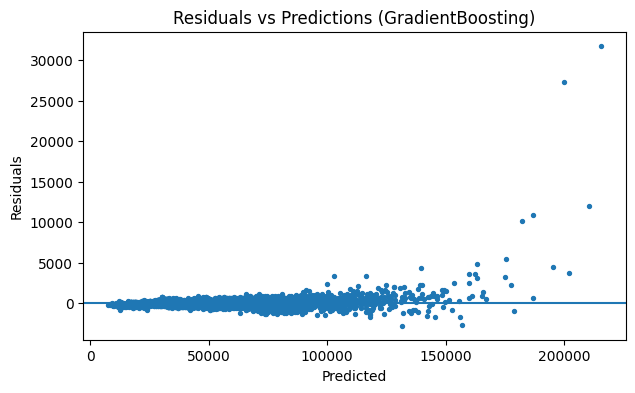

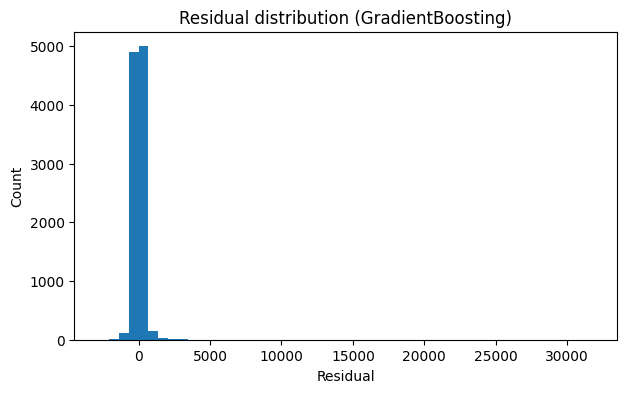

In [18]:
# ===== Cell 10: Residual plots for the best model (assume RF for example) =====
best_name = score_df.iloc[0]["Model"]
print("Best model:", best_name)

best_pred = {"Linear": pred_va_lin, "RandomForest": pred_va_rf, "GradientBoosting": pred_va_gb}[best_name]
resid = y_valid.values - best_pred

plt.figure(figsize=(7,4))
plt.scatter(best_pred, resid, s=8)
plt.axhline(0)
plt.title(f"Residuals vs Predictions ({best_name})")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()

plt.figure(figsize=(7,4))
plt.hist(resid, bins=50)
plt.title(f"Residual distribution ({best_name})")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.show()


In [ ]:
Time series cross validation

In [22]:
# ===== Cell 11: Time-series CV (expanding by date) =====
def expanding_time_splits(df, n_splits=5, min_train_days=90, val_days=28):
    dates = np.sort(df["Date"].unique())
    splits = []
    start_idx = 0
    while len(splits) < n_splits:
        train_end_idx = start_idx + min_train_days
        val_end_idx   = train_end_idx + val_days
        if val_end_idx >= len(dates): break
        train_end_date = dates[train_end_idx]
        val_end_date   = dates[val_end_idx]

        tr_mask = df["Date"] <= train_end_date
        va_mask = (df["Date"] > train_end_date) & (df["Date"] <= val_end_date)
        splits.append((df.index[tr_mask], df.index[va_mask]))
        start_idx += val_days  # move forward by a fold window
    return splits

cv_splits = expanding_time_splits(train_fe, n_splits=4, min_train_days=120, val_days=28)

def cv_evaluate(pipe, X, y, splits):
    rows = []
    for i, (tr_idx, va_idx) in enumerate(splits, 1):
        pipe.fit(X.iloc[tr_idx], y.iloc[tr_idx])
        pred = pipe.predict(X.iloc[va_idx])
        m = regression_metrics(y.iloc[va_idx], pred)
        rows.append({"Fold": i, **m})
    return pd.DataFrame(rows)

cv_rf = cv_evaluate(rf_pipe, train_fe[feature_cols], train_fe[TARGET], cv_splits)
cv_gb = cv_evaluate(gb_pipe, train_fe[feature_cols], train_fe[TARGET], cv_splits)
cv_lin = cv_evaluate(lin_pipe, train_fe[feature_cols], train_fe[TARGET], cv_splits)

cv_rf, cv_gb, cv_lin


(   Fold        MAE        RMSE     MAPE%
 0     1  69.222835  249.245944  0.132448
 1     2  92.113293  776.388969  0.126056
 2     3  78.828366  556.288595  0.116899
 3     4  43.986149  190.923423  0.115223,
    Fold         MAE        RMSE     MAPE%
 0     1  242.320148  340.286785  0.561984
 1     2  254.929000  634.796138  0.555476
 2     3  225.919052  369.296065  0.496374
 3     4  209.527024  292.554894  0.571693,
    Fold          MAE         RMSE     MAPE%
 0     1  1569.322387  2114.338964  4.336016
 1     2  1464.110365  2266.932849  3.677283
 2     3  1233.875067  1983.392070  2.858509
 3     4  1253.739463  1820.863364  4.071256)

In [ ]:
Train Final Model on Full Train & Predict Test

In [23]:
# ===== Cell 12: Fit best model on full train & predict test =====
best_model_name = score_df.iloc[0]["Model"]
model_map = {"Linear": lin_pipe, "RandomForest": rf_pipe, "GradientBoosting": gb_pipe}
best_pipe = model_map[best_model_name]

# Use all rows that have complete features for training
X_full = train_fe[feature_cols].copy()
y_full = train_fe[TARGET].copy()
best_pipe.fit(X_full, y_full)

# Prepare test features (drop rows without lags)
test_ready = test_fe.dropna(subset=["Sales_lag1","Sales_roll7","Orders_lag1","Orders_roll7"]).copy()
X_test = test_ready[feature_cols].copy()
test_pred = best_pipe.predict(X_test)

# Build submission frame
sub = test_ready[["ID","Store_id","Date","Store_Type","Location_Type","Region_Code","Holiday","Discount","#Order"]].copy()
sub["Predicted_Sales"] = test_pred

print("Test predictions:", sub.shape)
sub.head()


Test predictions: (365, 10)


,ID,Store_id,Date,Store_Type,Location_Type,Region_Code,Holiday,Discount,#Order,Predicted_Sales
188340,T1188651,1,2019-06-01,S1,L3,R1,0,No,NaN,39291.856954
188401,T1188635,2,2019-06-01,S3,L1,R3,0,No,NaN,39291.856954
188462,T1188669,3,2019-06-01,S4,L2,R1,0,No,NaN,39183.441199
188523,T1188630,4,2019-06-01,S1,L1,R2,0,No,NaN,39293.727279
188584,T1188590,5,2019-06-01,S1,L1,R3,0,No,NaN,39291.856954


In [ ]:
Save Artifacts for Deployement

In [24]:
# ===== Cell 13: Save outputs =====
os.makedirs("ml_outputs", exist_ok=True)

# Predictions
sub_path = "ml_outputs/test_predictions.csv"
sub.to_csv(sub_path, index=False)

# (Optional) Save the pipeline/model with joblib for Flask deployment
try:
    import joblib
    model_path = "ml_outputs/best_model_pipeline.joblib"
    joblib.dump(best_pipe, model_path)
    print(f"Saved: {sub_path}\nSaved: {model_path}")
except Exception as e:
    print(f"Saved: {sub_path}\njoblib not available: {e}")


Saved: ml_outputs/test_predictions.csv
Saved: ml_outputs/best_model_pipeline.joblib
